# A Simple Speech Emotion Recognition System

This notebook shows how to create a simple Speech Emotion Recognition (SER) system using [OpenSmile's](https://www.audeering.com/research/opensmile/) ComParE 2006 feature set of statistical functionals. The dataset used was the [EmoDB](http://emodb.bilderbar.info/start.html) dataset of emotional speech, with utterances in german for 7 different emotions (including neutral), spoken by 10 different actors and 10 different sentences. The SER system uses a simple K Nearest Neighbours classifier from the [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) toolkit.

This notebook is for demonstration purposes only, and only provides you with a very simple SER system. In truth, a linear SVC would provide better results than the KNN, however the results are more interesting using the KNN.

As part of this code you will also find:<br>
-preprocess_emodb.py: Here you will find the code used for preprocessing the EmoDB dataset.



To make sure this code runs correctly, download the [EmoDB dataset](http://emodb.bilderbar.info/start.html), extract the .zip file, store it in the main folder of this project, and rename it "EmoDB".

In [1]:
# main imports. you may have to install some of the libraries, for example using pip. Check the respective
# website for more information on how to install them correctly.

import os
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm

import opensmile

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

## EmoDB data
Let's have a short look at the EmoDB data. The *EmoDB_data* class provides us with some simple methods to explore our dataset.

In [2]:
# import this class to easily handle the EmoDB data
from preprocess_emodb import EmoDB_data
emodb = EmoDB_data()

The sentences spoken out by the EmoDB actors are quite funny. Here you can see the original (german) and the english version of each. 

In [3]:
emodb.get_sentences_info()

,german,english
a01,Der Lappen liegt auf dem Eisschrank.,The tablecloth is lying on the frigde.
a02,Das will sie am Mittwoch abgeben.,She will hand it in on Wednesday.
a04,Heute abend könnte ich es ihm sagen.,Tonight I could tell him.
a05,Das schwarze Stück Papier befindet sich da obe...,The black sheet of paper is located up there b...
a07,In sieben Stunden wird es soweit sein.,In seven hours it will be.
b01,"Was sind denn das für Tüten, die da unter dem ...",What about the bags standing there under the t...
b02,Sie haben es gerade hochgetragen und jetzt geh...,They just carried it upstairs and now they are...
b03,An den Wochenenden bin ich jetzt immer nach Ha...,Currently at the weekends I always went home a...
b09,Ich will das eben wegbringen und dann mit Karl...,I will just discard this and then go for a dri...
b10,"Die wird auf dem Platz sein, wo wir sie immer ...",It will be in the place where we always store it.


As you can see in the dataframe below, we have ten actors that read out the sentences with different emotions. There are 5 male and 5 female voices, with ages between 21 and 35. One thing that is important is that when we test the performance of our dataset, the testset is completely independent of the training set. This means, not only the samples that we use should not be the same. We should also try to test with speakers that were not in the training dataset. Otherwise out test results may be too optimistic, but not account for new voices it has never heard before. In other words, testing with new speekers increases the validity of our measurement of the empirial risk.

In [4]:
emodb.get_speaker_info()

,gender,age
03,male,31
08,female,34
09,female,21
10,male,32
11,male,26
12,male,30
13,female,32
14,female,35
15,male,25
16,female,31


Next, we should also have an idea of which emotions we are trying to predict, i.e. which labels we are using. In the following example we will use 7 different emotions, as provided by EmoDB. However, we could also choose to use valence labels, which are binary.

In [5]:
emodb.get_emotions_info()

,emotion,valence
W,anger,negative
L,boredom,negative
E,disgust,negative
A,fear,negative
F,happiness,positive
T,sadness,negative
N,neutral,positive


Before we start training, let's have another look at the dataset that we are using. There are 535 samples, and opensmile provides us with 6373 unique features ([ComParE 2016 feature set](http://www.tangsoo.de/documents/Publications/Schuller16-TI2.pdf)). What each feature represents you can see in the table below as well. They comprise of statistical functionals of different Low Level Descriptors that describe different audio features at short intervals of time for each audio file.
The training data will be composed of the features (X) and the labels (y). Below you can also check the 7 different labels that will be used and how often they occur in the dataset.

In [6]:
# We could alternatively use the valence labels, however this would make the system less interesting and we
# would need to account for the imbalance in the dataset, as most emotions in the dataset are negative.
# X, y = emodb.get_full_training_data(labeling="valence")
X, y = emodb.get_full_training_data(labeling="emotion")

In [7]:
# There are 535 samples with 6373 features
X.shape

(535, 6373)

In [8]:
columns = list(emodb._get_audio_info().columns)
columns[3:10] + columns[-7:]

['audspec_lengthL1norm_sma_range',
 'audspec_lengthL1norm_sma_maxPos',
 'audspec_lengthL1norm_sma_minPos',
 'audspec_lengthL1norm_sma_quartile1',
 'audspec_lengthL1norm_sma_quartile2',
 'audspec_lengthL1norm_sma_quartile3',
 'audspec_lengthL1norm_sma_iqr1-2',
 'mfcc_sma_de[14]_peakMeanMeanDist',
 'mfcc_sma_de[14]_peakMeanRel',
 'mfcc_sma_de[14]_minRangeRel',
 'mfcc_sma_de[14]_meanRisingSlope',
 'mfcc_sma_de[14]_stddevRisingSlope',
 'mfcc_sma_de[14]_meanFallingSlope',
 'mfcc_sma_de[14]_stddevFallingSlope']

In [9]:
pd.DataFrame(y, columns=["Emotion"]).value_counts()

Emotion  
anger        127
boredom       81
neutral       79
happiness     71
fear          69
sadness       62
disgust       46
dtype: int64

## Optimization and Training
Now that we already know more or less what data we are working with, let's start the training process. 
To keep this simple, this notebook will only cover a very simple model class: a KNN classifier, which selects for k nearest neighbours and selects the majority class of these neighbours. 

This section is divided into three parts: 
1) First, we will go through several training runs in order to optimize for the n_neighbours hyperparameter to select the number of neighborus, using Group-K-fold validation to make sure each actor is either in the training or test set on each fold.

2) We will evaluate the results on the training and test sets to determine the best performing hyperparameter.

3) Train the final SER system and store it.


In general, for the optimization of the hyperparameters, the training set is split into a training and validation set. However, because the dataset is quite small, the validation set would probably yield suboptimal hyperparameters.

#### Optimizing the hyperparameter

In [10]:
# This function calculates some of the main metrics that will be used to evaluate the results.
def get_score(true_labels, predictions, labels):
    scores = pd.Series(dtype=float)
    scores["UAR"] = recall_score(true_labels, predictions, average='macro')
    scores["WAR"] = recall_score(true_labels, predictions, average='weighted')
    
    f1_scores = f1_score(true_labels, predictions, average=None, labels=labels)
    for label, f1 in zip(labels, f1_scores):
        scores[f"f1_{label}"] =  f1
    scores["f1_mean"] = f1_scores.mean()  

    cm = confusion_matrix(true_labels, predictions, labels=labels)
    
    return scores, cm


In [11]:
# Some hyperparameters for our search and optimization. 
k_folds = 5      #number of folds
hyperparameter_space = range(1, 40)

In [12]:
# Here we will store the results
results_val = pd.DataFrame()
results_train = pd.DataFrame()
confusion_matrices = {}
labels = emodb.emotions["emotion"].to_list()

for n_neighbors in hyperparameter_space:
    confusion_matrices[n_neighbors] = {}

# the EmoDB_data class already has a method that provides the necessary datasets for training, validating
# and testing the models using Group_K_Fold for validation and GroupShuffleSplit for testing

folds_data, X_train_val, y_train_val, X_test, y_test = emodb.get_train_val_test_folds()

for k, train_val_split in tqdm(enumerate(folds_data)):
    X_train = train_val_split["X_train"]
    X_val = train_val_split["X_val"]
    y_train = train_val_split["y_train"]
    y_val = train_val_split["y_val"]
    
    
    # Normalize the values
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    
    # let us go through different values for the hyperparameter we are optimizing
    for n_neighbors in hyperparameter_space:
        
        
        clf = KNeighborsClassifier(n_neighbors=n_neighbors)
        clf.fit(X_train, y_train)
        
        # calculate the performance on the validation set and store values
        val_predictions = clf.predict(X_val)
        scores, confusion_matrices[n_neighbors][k] = get_score(y_val, val_predictions, clf.classes_)
        scores["n_neighbors"] = n_neighbors
        scores["k_fold"] = k
        
        #make sure confusion matrix is ordered correctly:
        permutation = [list(clf.classes_).index(element) for element in labels]
        confusion_matrices[n_neighbors][k][permutation][:, permutation]
        
        results_val = pd.concat([results_val, scores], axis=1)
        
        # calculate the performance on the train set and store values
        train_predictions = clf.predict(X_train)
        scores, _ = get_score(y_train, train_predictions, clf.classes_)
        scores["n_neighbors"] = n_neighbors
        scores["k_fold"] = k
        
        results_train = pd.concat([results_train, scores], axis=1)
        
        
        
results_val = results_val.T
results_train = results_train.T


5it [00:25,  5.06s/it]


#### Evaluation

Now that the classifier has tried different values for the hyperparameter for k=5 folds of training and validation sets, we can evaluate the results. 

The first graph shows the Weighted Average Recall over the different values of the hyperparameter that we tested for both the training and the test set. For too low number of neighbours, the WAR score for the training set is actually quite high and almost constantly drops with increasing number of neighbours. On the validation set, however, it starts by increasing for low number of neighbours, and then reaches a point where it starts to gently get lower again (after 13 or 25 neighbours). 

Besides learning which are the best values for the hyperparameter (the max WAR value of the validation set), we can also observe a particular trend: Overfitting with low n_neighbours values, peak performance with moderate generalization and then slight decline in performance towards underfitting.

This also aludes to another thing that we must be careful about: Having a test set that is much to similar to the training set could give the impression that the performance of our model is much better than it will actually be in the real world.

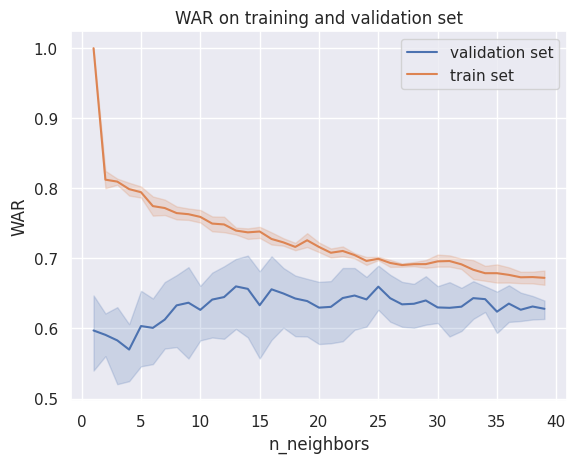

In [13]:
plot = sns.lineplot(data=results_val, x="n_neighbors", y="WAR", label="validation set")
plot = sns.lineplot(data=results_train, x="n_neighbors", y="WAR", label="train set")
plot.set_title("WAR on training and validation set")
plt.show()

Weighted Average Recall is, in general, a very interesting metric for this kind of study, since it gives us a better understanding about how often the classifier is right, weighted in order to measure the different labels equally. However, if we look at the F1 score for the different emotions in the table below, we notice that the classifier has a good performance on Sadness or even Anger, while being really bad at detecting Happiness. In general, we could use recall and precision to understand better what is going on, however, there is another way to really understand what our model is misinterpreting.

In [14]:
mean_results = results_val.drop("k_fold", axis=1).groupby("n_neighbors").mean().reset_index()
top_index = mean_results["WAR"].argmax()
top_neighbors = int(mean_results.loc[top_index, "n_neighbors"])
mean_results.loc[top_index]

n_neighbors     13.000000
UAR              0.629130
WAR              0.660013
f1_anger         0.735228
f1_boredom       0.715378
f1_disgust       0.592331
f1_fear          0.431124
f1_happiness     0.191919
f1_neutral       0.705157
f1_sadness       0.810499
f1_mean          0.597376
Name: 12, dtype: float64

Below we can see a Confusion Matrix. It shows the amount of samples in the test set that have a particular true value, and how our classifier predicted them. Similar to the confusion matrix in binary classification that gives us the True Positives, True Negatives and the False positives or negatives, with multiclass classification, we see which labels were confounded with which. 
In general, it is interesting to look at the values outside the diagonal of correctly classifier samples to understand how the classifier is wrong, and what would be the cause.
In our particular case, we see that Anger was quite often correct, however sometimes mistaken for either happiness, or even fear or disgust. The other way round, Happiness was more often classifier as Anger than Happiness itself. Of course, one can try to imagine that maybe emotions are hard to distinguish, both for humans and for computers, however, the inbalance in the dataset can also be a major cause (remember that Anger was the most common label, while Happiness the least common).


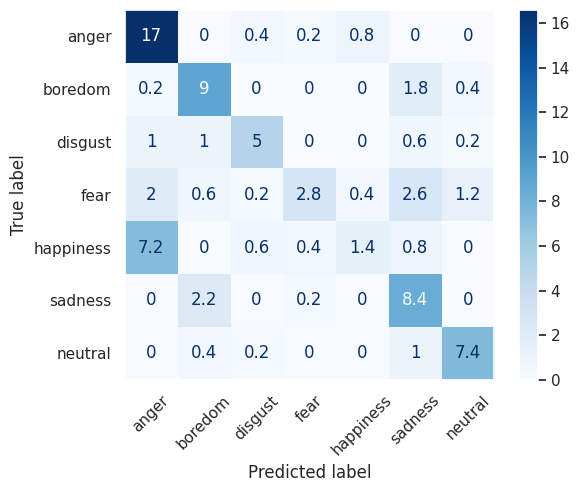

In [15]:
# get confusion matrix for top neighbor hyperparameter, averaged over the kfolds
top_cm = np.array(list(confusion_matrices[top_neighbors].values())).mean(axis=0)
    

disp = ConfusionMatrixDisplay(confusion_matrix=top_cm, display_labels=labels).plot(cmap="Blues")
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

#### Testing

Now, in the previous section we chose the hyperparameter with the highest WAR score. We could of course also have chosen the one with the best score for Happiness, or any other metric that might be more important to us or a customer. It is now time to test the model and the chosen hyperparameters and give an estimate of its performance. Let's test on the test set!

In [16]:
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)
X_test_scaled = scaler.transform(X_test)

clf = KNeighborsClassifier(n_neighbors=top_neighbors)
clf.fit(X_train_val_scaled, y_train_val)

test_predictions = clf.predict(X_test_scaled)
scores, cm_test = get_score(y_test, test_predictions, clf.classes_)
scores

UAR             0.704887
WAR             0.738255
f1_anger        0.781609
f1_boredom      0.897959
f1_disgust      0.769231
f1_fear         0.461538
f1_happiness    0.312500
f1_neutral      0.758621
f1_sadness      0.969697
f1_mean         0.707308
dtype: float64

Here we are! The WAR score on the testset is not that bad! 73% WAR with a nearly perfect F1 score for Sadness is quite good for such a simple SER system! Other emotions also score relatively high, except for Happiness :'( 

From the confusion matrix, the issue seems to be the same. Well, I guess we can at least laugh every time it's wrong!
 

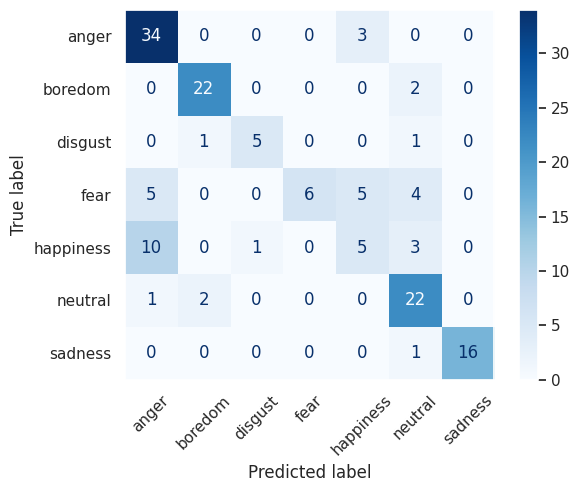

In [17]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=clf.classes_).plot(cmap="Blues")
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

#### Final training
Now that we have tested our best performing hyperparameter for the number of neighbours for the KNN classifier, and have some understanding of how it would perform on unseen data, it is time to train the final classifier on the whole dataset that we have available. Hopefully it works a bit better, however there is no way to measure it unless we gather more data.

In [18]:
X, y = emodb.get_full_training_data(labeling="emotion")

scaler = StandardScaler()
X = scaler.fit_transform(X)

clf = KNeighborsClassifier(n_neighbors=top_neighbors)
clf.fit(X_train, y_train)

pickle.dump(scaler, open('scaler.pkl', 'wb'))
pickle.dump(clf, open('classifier.pkl', 'wb'))

## Make it ready to use!
Now, lets have a Simple Speech Emotion Recognizer class that is ready to be used. Once instantiated, one can just ask it to *predict* a .wav file with a voice recording and get the (hopefully) correct emotion.

In [19]:
class SimpleSpeechEmotionRecognizer():

    def __init__(self, warnings=True):
        self.smile = opensmile.Smile(
            feature_set=opensmile.FeatureSet.ComParE_2016,
            feature_level=opensmile.FeatureLevel.Functionals,
        )
        
        self.scaler = pickle.load(open("scaler.pkl", 'rb'))
        self.classifier = pickle.load(open("classifier.pkl", 'rb'))
        
    def _get_opensmile_from_wav(self, file_path: str):
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"'{file_path}' was not found")

        data = self.smile.process_file(file_path)

        data = pd.DataFrame(data).reset_index()
        return data
    
    def predict(self, file_path: str)->str:
        data = self._get_opensmile_from_wav(file_path=file_path)
        
        X = data.drop(["file", "start", "end"], axis=1).copy().to_numpy()
        X = self.scaler.transform(X)
        prediction = self.classifier.predict(X)[0]

        return prediction


#### Let's test it out

In [20]:
simple_SER = SimpleSpeechEmotionRecognizer()

In [21]:
# in the file name 03a01Wa.wav, the "W" letter stands for "Wut", meaning Anger in german
simple_SER.predict("EmoDB/wav/03a01Wa.wav")

'anger'

## Future improvements

Of course, this is a really simple implementation of a Speech Emotion Recognition, and rather serves to get to understand the datasets and the methods for training and testing a little better. As said at the beginning, even a Linear SVM classifier would perform better. KNN classifiers tend to perform really bad with datasets with large amounts of features, and here we were using > 600!

One interesting path would be to reduce the number of features: If we smartly select only some of the features, the performance might improve. Another method would be to use dimensionality reduction methods such as PCA. 
Of course there are a lot of other model classes that can be tried out, as well as ensembles of these.
Another thing that can be used are other features: Instead of using the statistical functionals of ComParE 2026, one could use the Low Level Descriptors to have feature vectors describing each 10ms of sound signal. Tying this up with some LSTM networks (or even CNNs) would better capture the huge amount of detail and complexity required for Speech Emotion Recognition.


Hope you enjoyed this little project and if you have any questions, feel free to contact me. 

Best regards, 

Vasco

